In [17]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import plotly.express as px
from functions import redshift_connection, create_redshift_df, train_evaluate_model, calculate_mean_shap_values
from sklearn.metrics import accuracy_score, confusion_matrix

In [18]:
results = redshift_connection()
df_redshift_data_all = create_redshift_df(results)

Connection to Redshift database successful
Database connection is active.
Redshift connection closed


In [19]:
df_redshift_data_all.to_csv('redshift_data.csv', index=False)

In [20]:
df_redshift_data_all.shape

(168, 27)

In [21]:
df_redshift_data_all.head()
# df_redshift_data_all.shape

,fixture_mid,home_team,away_team,home_score,away_score,team_name,kick_errors,rucks_won,rucks_lost,total_linebreaks,...,total_offloads,total_carries,total_carry_metres,total_carries_dominant,total_turnovers_conceded,total_penalties_conceded,total_carry_metres_post_contact,ruck_arrivals_attack_first2,ruck_arrivals_defence_first2,won_lost
0,01506546-a187-47f0-860d-db4b999d6eb4,Hurricanes,Blues,29,21,Blues,1,113,4,4,...,14,161,602,90,17,8,260,0,0,0
1,01506546-a187-47f0-860d-db4b999d6eb4,Hurricanes,Blues,29,21,Hurricanes,1,78,3,9,...,8,112,474,44,14,11,248,0,0,1
2,0235f1fc-5c68-4456-9ec3-da0ff022d3b8,NSW Waratahs,Blues,10,12,Blues,0,92,3,6,...,14,126,550,82,16,9,226,0,0,1
3,0235f1fc-5c68-4456-9ec3-da0ff022d3b8,NSW Waratahs,Blues,10,12,NSW Waratahs,0,89,4,3,...,8,121,475,70,12,15,283,0,0,0
4,07dfad23-6805-4a1e-b8b1-d176ba7bbbc1,Moana Pasifika,Reds,17,14,Moana Pasifika,4,72,3,4,...,7,98,377,32,18,6,255,0,0,1


In [22]:

# df_redshift_data_all = pd.read_csv('redshift_data.csv')
# df_redshift_data_all.shape

In [23]:
df_redshift_data_all['score_difference'] = df_redshift_data_all['home_score'] - df_redshift_data_all['away_score']

# Remove outliers based on the 'score_difference' column
z_scores = np.abs(stats.zscore(df_redshift_data_all['score_difference']))
df_redshift_data_all = df_redshift_data_all[z_scores < 3]

print("\nData after removing outliers:")
print(df_redshift_data_all.describe())
df_redshift_data_all.shape


Data after removing outliers:
       home_score  away_score  kick_errors   rucks_won  rucks_lost  \
count  168.000000  168.000000   168.000000  168.000000  168.000000   
mean    31.035714   22.619048     1.285714   83.196429    3.107143   
std     13.434647   11.535838     1.184444   21.170610    1.768100   
min      3.000000    0.000000     0.000000   30.000000    0.000000   
25%     21.750000   13.750000     0.000000   69.000000    2.000000   
50%     30.000000   21.500000     1.000000   82.000000    3.000000   
75%     40.000000   29.000000     2.000000   96.250000    4.000000   
max     68.000000   53.000000     5.000000  139.000000    8.000000   

       total_linebreaks  total_tries  total_supported_breaks  \
count        168.000000   168.000000              168.000000   
mean           5.809524     3.619048                2.833333   
std            2.851520     2.087343                2.465733   
min            1.000000     0.000000                0.000000   
25%            4.0

(168, 28)

In [24]:
# Define the features and target variable
X = df_redshift_data_all[['kick_errors',
            'rucks_won',
            'rucks_lost',
            'total_linebreaks',
            'total_tries',
            'total_supported_breaks',
            'total_defenders_beaten',
            'total_jackals_success',
            'total_intercepts',
            'total_tackles_made',
            'total_tackles_missed',
            'total_offloads',
            'total_carries',
            'total_carry_metres',
            'total_carries_dominant',
            'total_turnovers_conceded',
            'total_penalties_conceded', 
            'total_carry_metres_post_contact',
            'ruck_arrivals_attack_first2',
            'ruck_arrivals_defence_first2']]
y = df_redshift_data_all['won_lost']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random forest

In [25]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf, accuracy_rf, conf_matrix_rf, feature_importance_rf = train_evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)

# Create a DataFrame for feature importance
random_forest_feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_rf': rf.feature_importances_  # Use feature_importances_ for RandomForestClassifier
})

print("Random Forest Accuracy:", accuracy_rf)
print(feature_importance_rf)
random_forest_feature_importance_df.head()



Feature importance found
Random Forest Accuracy: 0.7352941176470589
                            feature  importance
0                       kick_errors    0.016609
1                         rucks_won    0.065276
2                        rucks_lost    0.046213
3                  total_linebreaks    0.064862
4                       total_tries    0.158832
5            total_supported_breaks    0.037822
6            total_defenders_beaten    0.043331
7             total_jackals_success    0.035246
8                  total_intercepts    0.018924
9                total_tackles_made    0.064235
10             total_tackles_missed    0.079033
11                   total_offloads    0.039081
12                    total_carries    0.038462
13               total_carry_metres    0.074933
14           total_carries_dominant    0.051323
15         total_turnovers_conceded    0.063548
16         total_penalties_conceded    0.047927
17  total_carry_metres_post_contact    0.046270
18      ruck_arrival

,feature,importance_rf
0,kick_errors,0.016609
1,rucks_won,0.065276
2,rucks_lost,0.046213
3,total_linebreaks,0.064862
4,total_tries,0.158832


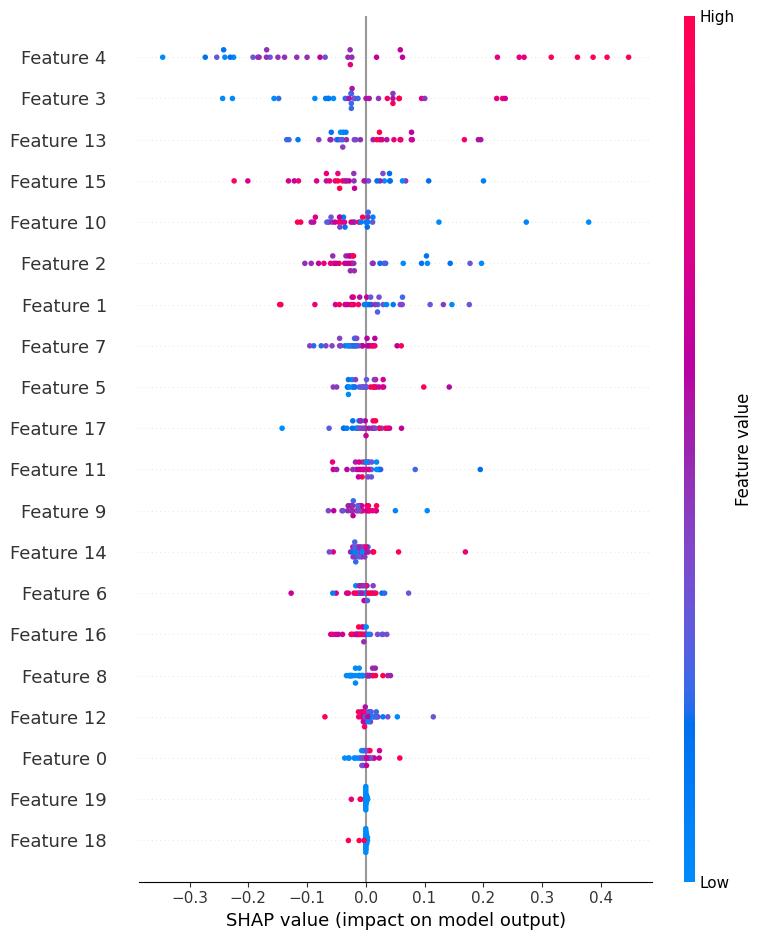

Mean SHAP values for each feature:
kick_errors: -0.0011
rucks_won: 0.0084
rucks_lost: 0.0012
total_linebreaks: -0.0052
total_tries: -0.0239
total_supported_breaks: 0.0014
total_defenders_beaten: -0.0063
total_jackals_success: -0.0191
total_intercepts: -0.0040
total_tackles_made: -0.0079
total_tackles_missed: -0.0117
total_offloads: 0.0036
total_carries: 0.0078
total_carry_metres: 0.0014
total_carries_dominant: -0.0047
total_turnovers_conceded: -0.0233
total_penalties_conceded: -0.0105
total_carry_metres_post_contact: -0.0037
ruck_arrivals_attack_first2: -0.0007
ruck_arrivals_defence_first2: -0.0005


In [26]:
# Create the SHAP Explainer
explainer = shap.Explainer(rf_model.predict, X_train_scaled)

# Calculate SHAP values for test set
shap_values = explainer(X_test_scaled)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test_scaled)

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X.columns, mean_shap_values))

print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")

Logistic Regression

In [27]:
# Logistic Regression
lr_model = LogisticRegression()
lr, accuracy_lr, conf_matrix_lr, feature_importance_lr = train_evaluate_model(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)
print("Logistic Regression Accuracy:", accuracy_lr)
print(feature_importance_lr.head(15))

log_regrssion_feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'coef_lr': lr.coef_[0]
})
log_regrssion_feature_importance_df.head()


Coef found
Logistic Regression Accuracy: 0.7647058823529411
                   feature      coef
0              kick_errors  0.654174
1                rucks_won -0.235105
2               rucks_lost -0.423522
3         total_linebreaks  0.870048
4              total_tries  1.414782
5   total_supported_breaks -0.446663
6   total_defenders_beaten  0.093112
7    total_jackals_success  0.477073
8         total_intercepts  0.570438
9       total_tackles_made  0.256537
10    total_tackles_missed -0.733432
11          total_offloads -0.278253
12           total_carries -0.326666
13      total_carry_metres  0.255659
14  total_carries_dominant  0.429188


,feature,coef_lr
0,kick_errors,0.654174
1,rucks_won,-0.235105
2,rucks_lost,-0.423522
3,total_linebreaks,0.870048
4,total_tries,1.414782


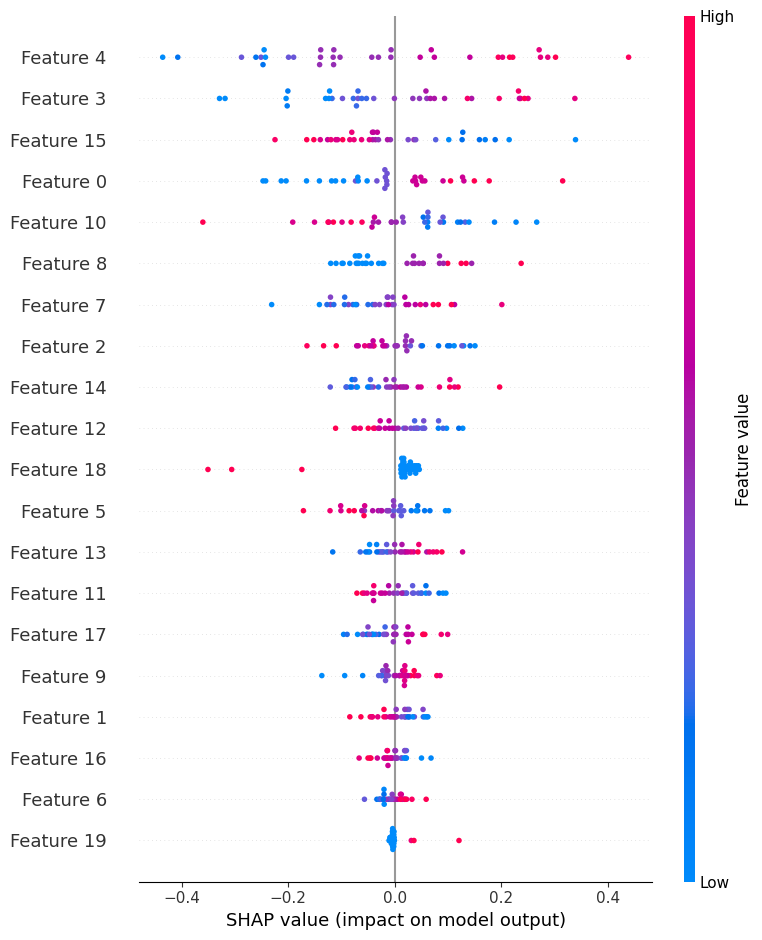

Mean SHAP values for each feature:
kick_errors: -0.0154
rucks_won: 0.0060
rucks_lost: 0.0090
total_linebreaks: 0.0048
total_tries: -0.0287
total_supported_breaks: -0.0152
total_defenders_beaten: -0.0031
total_jackals_success: -0.0231
total_intercepts: 0.0006
total_tackles_made: 0.0014
total_tackles_missed: 0.0114
total_offloads: 0.0080
total_carries: 0.0151
total_carry_metres: 0.0046
total_carries_dominant: -0.0055
total_turnovers_conceded: -0.0067
total_penalties_conceded: -0.0025
total_carry_metres_post_contact: -0.0104
ruck_arrivals_attack_first2: -0.0016
ruck_arrivals_defence_first2: 0.0018


In [28]:
# Create the SHAP Explainer
explainer = shap.Explainer(lr_model.predict, X_train_scaled)

# Calculate SHAP values for test set
shap_values = explainer(X_test_scaled)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test_scaled)

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X.columns, mean_shap_values))

print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")

XgBoost

In [29]:

import xgboost as xgb# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("XGBClassifier Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Feature importance
xgboost_feature_importance = pd.DataFrame({'feature': X.columns, 'importance_xgb': xgb_classifier.feature_importances_})
print("Feature Importance:\n", xgboost_feature_importance.sort_values(by='importance_xgb', ascending=False))

XGBClassifier Accuracy: 0.6176470588235294
Confusion Matrix:
 [[12  6]
 [ 7  9]]
Feature Importance:
                             feature  importance_xgb
4                       total_tries        0.238994
1                         rucks_won        0.107946
10             total_tackles_missed        0.073105
3                  total_linebreaks        0.066549
7             total_jackals_success        0.061302
11                   total_offloads        0.057346
14           total_carries_dominant        0.053838
6            total_defenders_beaten        0.052195
8                  total_intercepts        0.038806
15         total_turnovers_conceded        0.036198
9                total_tackles_made        0.035349
16         total_penalties_conceded        0.035322
2                        rucks_lost        0.033173
13               total_carry_metres        0.027790
17  total_carry_metres_post_contact        0.024560
0                       kick_errors        0.022334
5            t

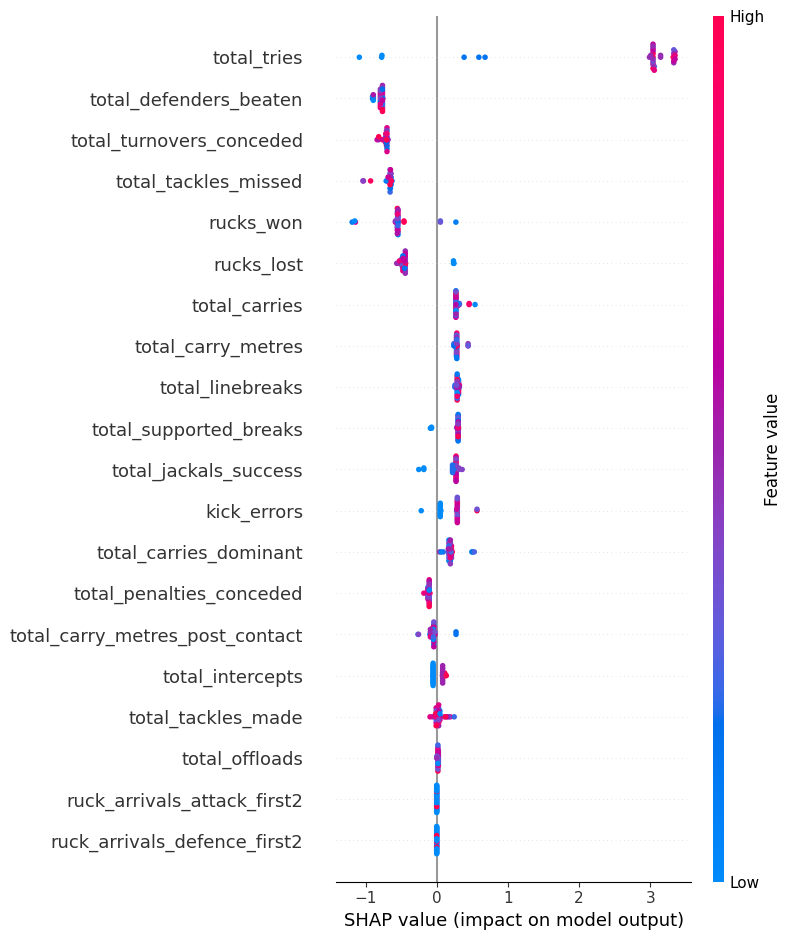

Mean SHAP values for each feature:
kick_errors: 0.2130
rucks_won: -0.5391
rucks_lost: -0.4047
total_linebreaks: 0.2909
total_tries: 2.5572
total_supported_breaks: 0.2668
total_defenders_beaten: -0.7955
total_jackals_success: 0.2252
total_intercepts: 0.0123
total_tackles_made: 0.0373
total_tackles_missed: -0.6856
total_offloads: 0.0168
total_carries: 0.2936
total_carry_metres: 0.2912
total_carries_dominant: 0.2049
total_turnovers_conceded: -0.7189
total_penalties_conceded: -0.1125
total_carry_metres_post_contact: -0.0481
ruck_arrivals_attack_first2: 0.0000
ruck_arrivals_defence_first2: 0.0000


In [30]:
# Create the SHAP Explainer
explainer = shap.Explainer(xgb_classifier)

# Calculate SHAP values for test set
shap_values = explainer(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X_test.columns, mean_shap_values))
print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")



In [31]:
from sklearn.svm import SVC
# from sklearn.neural_network import MLPClassifier

# SVM with a linear kernel
svm_model = SVC(kernel='linear')
svm, accuracy_svm, conf_matrix_svm, feature_importance_svm = train_evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)

# # MLP Neural Network
# mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
# mlp, accuracy_mlp, conf_matrix_mlp, _ = train_evaluate_model(mlp_model, X_train_scaled, y_train, X_test_scaled, y_test)
 
print("SVM Accuracy:", accuracy_svm)
print(feature_importance_svm)
# print("MLP Neural Network Accuracy:", accuracy_mlp)
# print( _ )

Coef found
SVM Accuracy: 0.7058823529411765
                            feature      coef
0                       kick_errors  0.694986
1                         rucks_won  0.088666
2                        rucks_lost -0.514160
3                  total_linebreaks  0.874609
4                       total_tries  1.221387
5            total_supported_breaks -0.249915
6            total_defenders_beaten -0.051990
7             total_jackals_success  0.608799
8                  total_intercepts  0.391450
9                total_tackles_made  0.220121
10             total_tackles_missed -0.665505
11                   total_offloads -0.409316
12                    total_carries -0.493193
13               total_carry_metres  0.283989
14           total_carries_dominant  0.389744
15         total_turnovers_conceded -0.743458
16         total_penalties_conceded -0.040919
17  total_carry_metres_post_contact  0.473880
18      ruck_arrivals_attack_first2 -0.345204
19     ruck_arrivals_defence_first2 

In [32]:
# Merge the DataFrames on the 'feature' column
merged_df = log_regrssion_feature_importance_df.merge(random_forest_feature_importance_df, on='feature')
merged_df = merged_df.merge(xgboost_feature_importance, on='feature')
merged_df.to_csv('output/feature_importance_merged.csv', index=False)

